---
## Import Library

In [1]:
#Modifikasi
import warnings
import zipfile
import numpy as np
import pandas as pd
from pathlib import Path
pd.set_option('display.max_columns', 100)

#Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px
import plotly.subplots as sp
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams

#Perhitungan
import itertools
from statsmodels.formula.api import ols
import statsmodels.api as sm
from geopy.geocoders import Nominatim
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose


#Imputasi
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


# Modeling
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, GroupKFold,KFold, TimeSeriesSplit   
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc,roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Feature Importance
from sklearn.ensemble import ExtraTreesClassifier

---
## Load Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

---
## Data Understanding

In [3]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [4]:
test.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [5]:
sample_submission.head()

,ID,prediction
0,28800,0.5
1,28801,0.5
2,28802,0.5


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [7]:
train.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,24606.000000,28800.000000,24499.000000,26992.000000,26235.000000,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,1.773795,2015.179444,1.703743,42.511591,1.719916,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,0.427130,3.153914,0.462213,15.251434,0.454449,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000,2008.000000,0.000000,18.010000,0.000000,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,2.000000,2013.000000,1.000000,28.447000,1.000000,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2016.000000,2.000000,40.063000,2.000000,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2018.000000,2.000000,56.131500,2.000000,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2020.000000,2.000000,84.800000,2.000000,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      3 non-null      int64  
 1   dri_score               3 non-null      object 
 2   psych_disturb           3 non-null      object 
 3   cyto_score              1 non-null      object 
 4   diabetes                3 non-null      object 
 5   hla_match_c_high        2 non-null      float64
 6   hla_high_res_8          2 non-null      float64
 7   tbi_status              3 non-null      object 
 8   arrhythmia              3 non-null      object 
 9   hla_low_res_6           3 non-null      float64
 10  graft_type              3 non-null      object 
 11  vent_hist               3 non-null      object 
 12  renal_issue             3 non-null      object 
 13  pulm_severe             3 non-null      object 
 14  prim_disease_hct        3 non-null      object

In [9]:
test.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10
count,3.0,2.0,2.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.000000,3.0,1.00,3.0,3.000000,3.0,3.0,3.000000,3.0,3.0,3.0,3.0
mean,28801.0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2014.333333,2.0,72.29,2.0,29.214667,2.0,2.0,1.000000,90.0,8.0,2.0,10.0
std,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.686241,0.0,NaN,0.0,17.382119,0.0,0.0,1.732051,0.0,0.0,0.0,0.0
min,28800.0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2008.000000,2.0,72.29,2.0,9.942000,2.0,2.0,0.000000,90.0,8.0,2.0,10.0
25%,28800.5,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2012.000000,2.0,72.29,2.0,21.969500,2.0,2.0,0.000000,90.0,8.0,2.0,10.0
50%,28801.0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2016.000000,2.0,72.29,2.0,33.997000,2.0,2.0,0.000000,90.0,8.0,2.0,10.0
75%,28801.5,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2017.500000,2.0,72.29,2.0,38.851000,2.0,2.0,1.500000,90.0,8.0,2.0,10.0
max,28802.0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2019.000000,2.0,72.29,2.0,43.705000,2.0,2.0,3.000000,90.0,8.0,2.0,10.0


In [10]:
train.shape, test.shape, sample_submission.shape

((28800, 60), (3, 58), (3, 2))

In [11]:
for col in train.columns:
    print(f"Unique Value kolom {col} : {train[col].nunique()}")

Unique Value kolom ID : 28800
Unique Value kolom dri_score : 11
Unique Value kolom psych_disturb : 3
Unique Value kolom cyto_score : 7
Unique Value kolom diabetes : 3
Unique Value kolom hla_match_c_high : 3
Unique Value kolom hla_high_res_8 : 7
Unique Value kolom tbi_status : 8
Unique Value kolom arrhythmia : 3
Unique Value kolom hla_low_res_6 : 5
Unique Value kolom graft_type : 2
Unique Value kolom vent_hist : 2
Unique Value kolom renal_issue : 3
Unique Value kolom pulm_severe : 3
Unique Value kolom prim_disease_hct : 18
Unique Value kolom hla_high_res_6 : 6
Unique Value kolom cmv_status : 4
Unique Value kolom hla_high_res_10 : 8
Unique Value kolom hla_match_dqb1_high : 3
Unique Value kolom tce_imm_match : 8
Unique Value kolom hla_nmdp_6 : 5
Unique Value kolom hla_match_c_low : 3
Unique Value kolom rituximab : 2
Unique Value kolom hla_match_drb1_low : 2
Unique Value kolom hla_match_dqb1_low : 3
Unique Value kolom prod_type : 2
Unique Value kolom cyto_score_detail : 5
Unique Value kolo

In [12]:
catCols = train.select_dtypes(include='object')
numCols = train.select_dtypes(exclude='object')

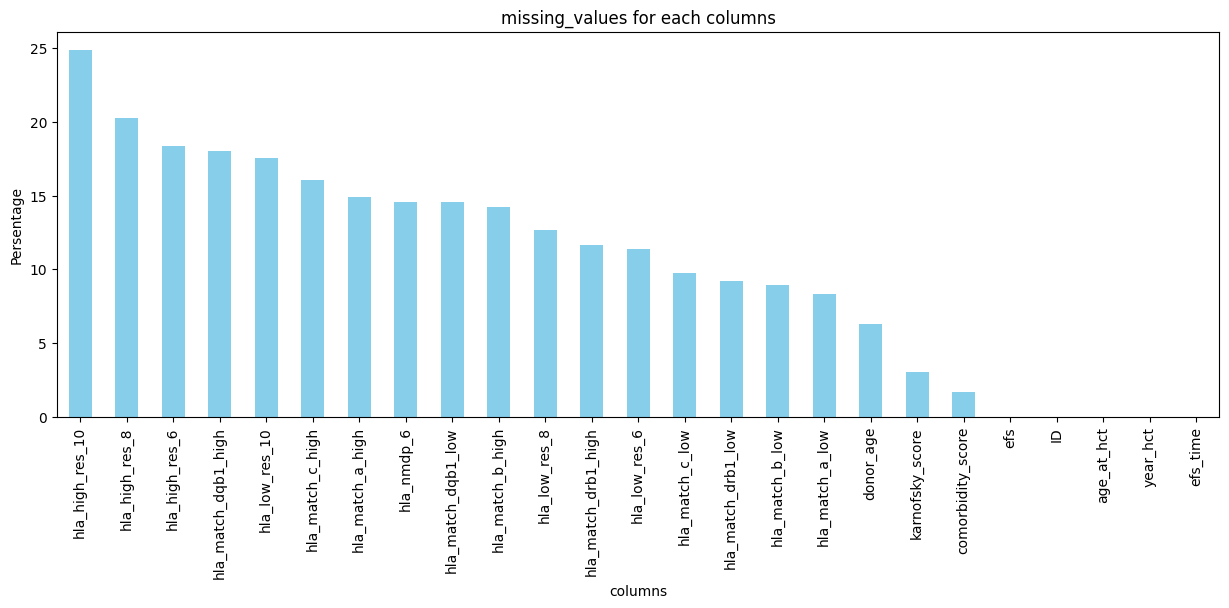

In [13]:
missing_values_numCols = ((numCols.isnull().sum() / len(numCols)) * 100).sort_values(ascending=False)
missing_values_numCols.plot(kind='bar',color='skyblue',figsize=(15,5))
plt.title("missing_values for each columns")
plt.xlabel("columns")
plt.ylabel("Persentage")
plt.show()

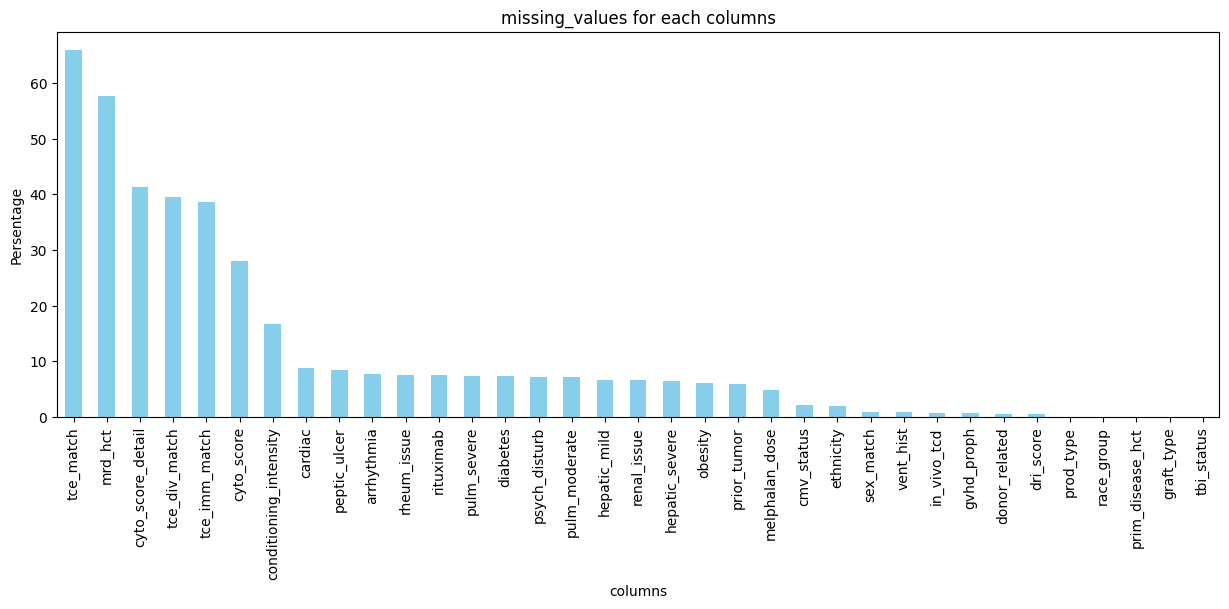

In [14]:
missing_values_catCols = ((catCols.isnull().sum() / len(catCols)) * 100).sort_values(ascending=False)
missing_values_catCols.plot(kind='bar',color='skyblue',figsize=(15,5))
plt.title("missing_values for each columns")
plt.xlabel("columns")
plt.ylabel("Persentage")
plt.show()

##### Karna lebih dari 60% better drop aja ya, dari pada isinya kacau

In [15]:
train.drop(['tce_match','mrd_hct','ID'],axis=1,inplace=True)

--- 
## Imputasi

In [16]:
# Imputasi menggunakan median atau mean
numerical_columns_median = [
    'hla_high_res_10', 'hla_high_res_8', 'hla_high_res_6', 'hla_match_dqb1_high', 
    'hla_low_res_10', 'hla_match_c_high', 'hla_match_a_high', 'hla_nmdp_6', 
    'hla_match_dqb1_low', 'hla_match_b_high', 'hla_low_res_8', 'hla_match_drb1_high', 
    'hla_low_res_6'
]

numerical_columns_mean = [
    'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_b_low', 'hla_match_a_low', 
    'donor_age', 'karnofsky_score', 'comorbidity_score'
]

# Imputasi median untuk kolom numerik dengan missing > 10%
for col in numerical_columns_median:
    train[col].fillna(train[col].median(), inplace=True)

# Imputasi mean untuk kolom numerik dengan missing < 10%
for col in numerical_columns_mean:
    train[col].fillna(train[col].mean(), inplace=True)

C:\Users\booma\AppData\Local\Temp\ipykernel_18632\159167003.py:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\booma\AppData\Local\Temp\ipykernel_18632\159167003.py:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [17]:
import xgboost as xgb
imputer_mode = SimpleImputer(strategy='most_frequent')

# Imputasi kolom-kolom dengan missing rendah menggunakan mode
low_missing_columns = ['cardiac', 'peptic_ulcer', 'arrhythmia', 'rheum_issue', 'rituximab', 'pulm_severe', 
                       'diabetes', 'psych_disturb', 'pulm_moderate', 'hepatic_mild', 'renal_issue', 'hepatic_severe', 
                       'obesity', 'prior_tumor', 'melphalan_dose', 'cmv_status', 'ethnicity', 'sex_match', 'vent_hist', 
                       'in_vivo_tcd', 'gvhd_proph', 'donor_related', 'dri_score']

train[low_missing_columns] = imputer_mode.fit_transform(train[low_missing_columns])

In [18]:
categorical_columns = ['cyto_score_detail', 'tce_div_match', 'tce_imm_match', 'cyto_score', 'conditioning_intensity']
le = LabelEncoder()
for col in categorical_columns:
    train[col] = le.fit_transform(train[col])
    
for col in categorical_columns:
    train[col].fillna(train[col].median(), inplace=True)


C:\Users\booma\AppData\Local\Temp\ipykernel_18632\2390542741.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\booma\AppData\Local\Temp\ipykernel_18632\2390542741.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

---
## Check Quasi Constant

In [19]:
df = train.copy()
le = LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['efs','efs_time'], axis=1),
    df['efs'],
    test_size=0.3,
    random_state=0)

# remove constant features
# using the code from the previous lecture

constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

#create an empty list
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = X_train[feature].value_counts(
        normalize=True).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:

        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

len(quasi_constant_feat)

0

##### Encode First then Check again

In [ ]:
binary_cols = [
    'psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue',
    'pulm_severe', 'obesity', 'prior_tumor', 'peptic_ulcer', 'hepatic_severe',
    'hepatic_mild', 'cardiac', 'pulm_moderate', 'rheum_issue', 'rituximab',
    'in_vivo_tcd', 'gvhd_proph', 'donor_related',
    'sex_match'
]
multi_class_cols = [
    'tbi_status', 'prod_type', 'cyto_score', 'cyto_score_detail',
    'conditioning_intensity', 'prim_disease_hct', 'graft_type',
    'cmv_status','ethnicity', 'race_group','race_group'
]

ordinal_cols = [
    'dri_score', 'tce_div_match', 'tce_imm_match',
    'hla_high_res_10', 'hla_high_res_8', 'hla_hzigh_res_6',
    'hla_low_res_10', 'hla_low_res_8', 'hla_low_res_6'
]

for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

df = pd.get_dummies(df, columns=multi_class_cols)

ordinal_encoder = OrdinalEncoder()
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

---
## For efs

##### Mutual Information

Text(0, 0.5, 'Mutual Information')

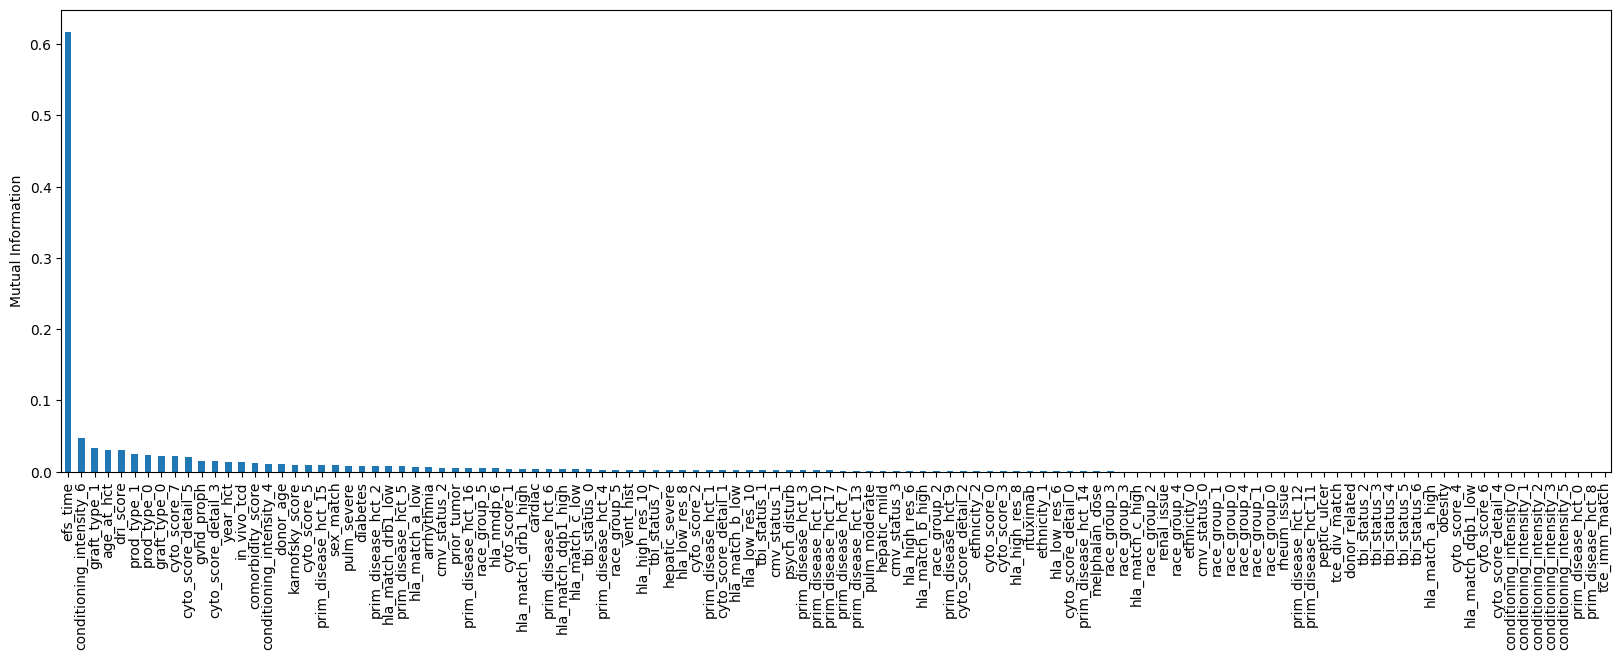

In [23]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['efs'], axis=1),
    df['efs'],
    test_size=0.3,
    random_state=0)

mi = mutual_info_classif(
    X = X_train, 
    y = y_train,
    discrete_features = False, 
    n_neighbors=3,
    random_state=3,
)

mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

##### ANOVA

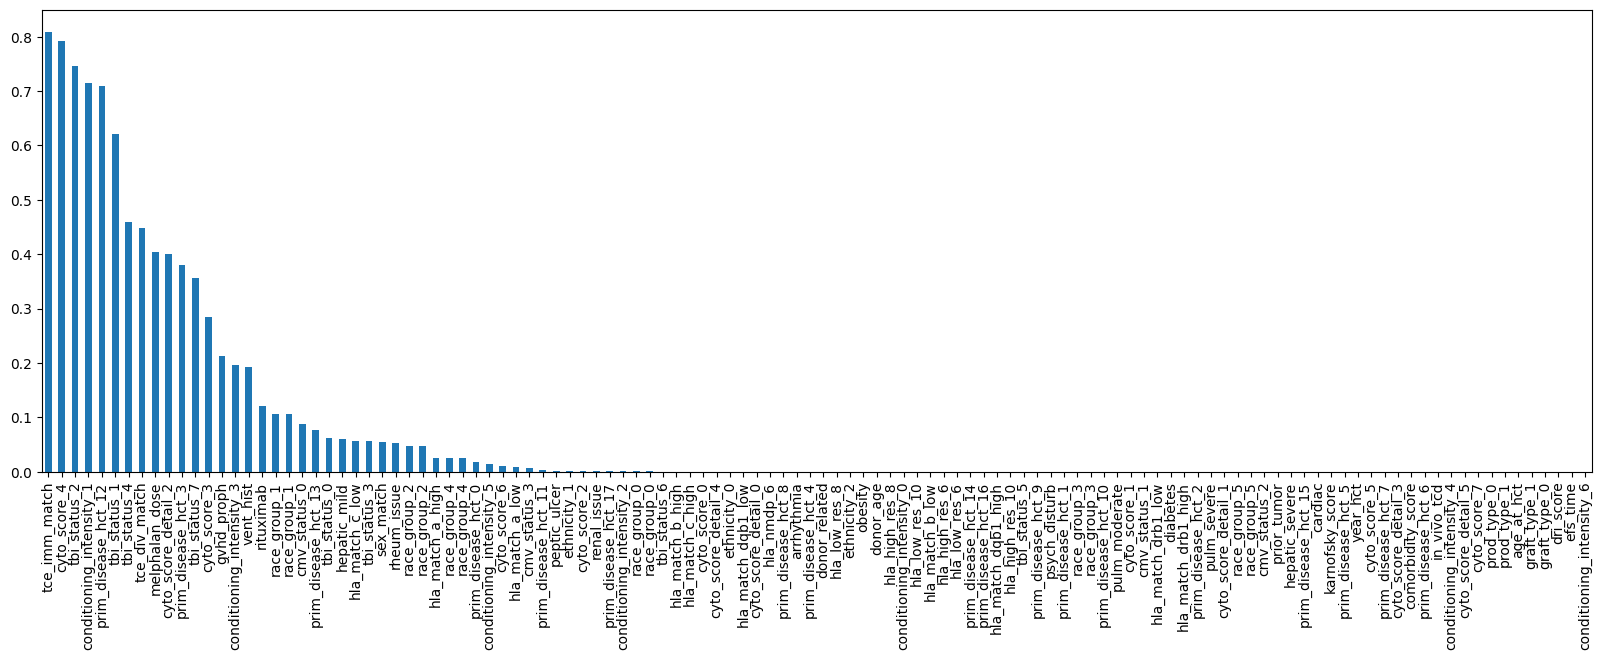

In [ ]:
from sklearn.feature_selection import f_classif
univariate = f_classif(X_train, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns 
univariate.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.show()

In [25]:
sel_ = SelectKBest(f_classif, k=10)

### Step Forward

---
## For efs_time

#### Mutual Information

Text(0, 0.5, 'Mutual Information')

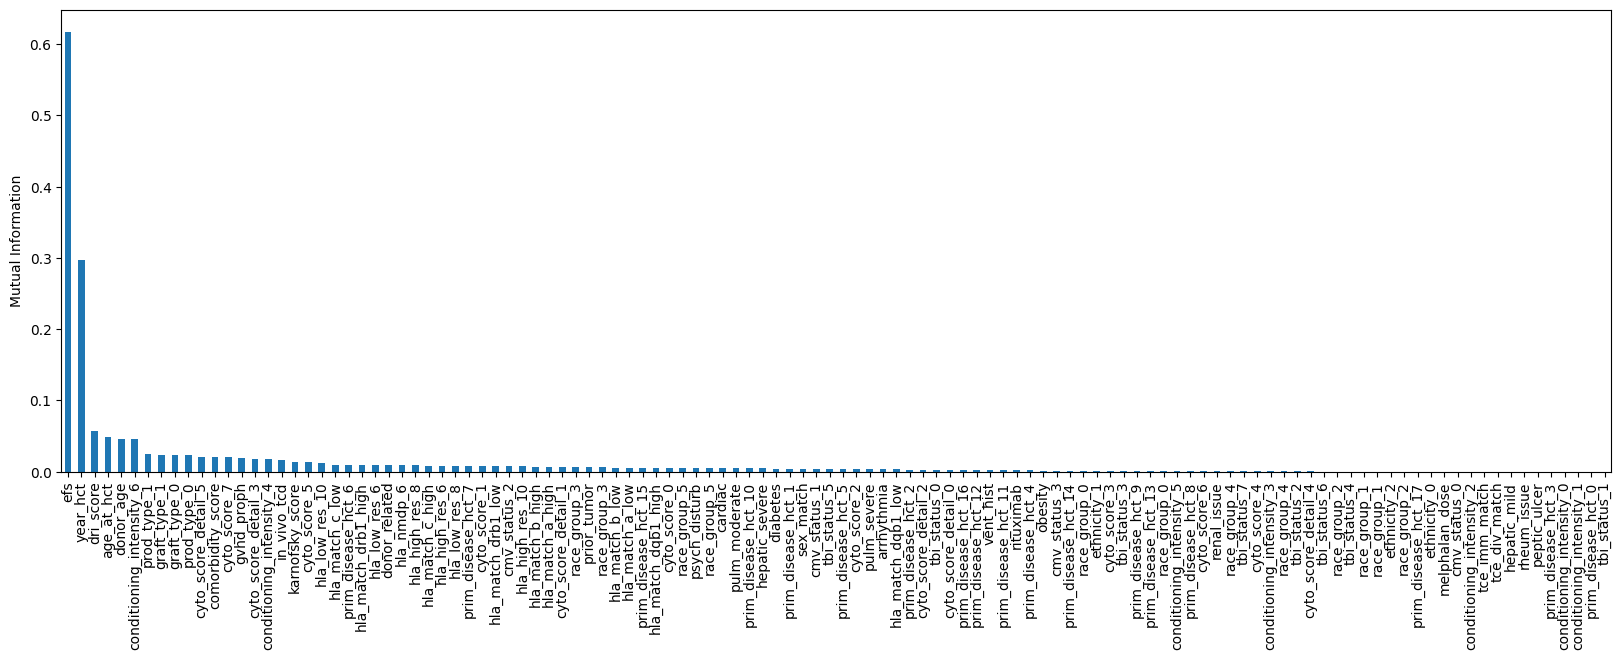

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['efs_time'], axis=1),
    df['efs_time'],
    test_size=0.3,
    random_state=0)

# Deteksi secara otomatis berdasarkan tipe data
discrete_features = [i for i, dtype in enumerate(X_train.dtypes) if dtype == 'int64' or dtype == 'float64']

mi = mutual_info_regression(
    X = X_train, 
    y = y_train,
    discrete_features = discrete_features, 
    n_neighbors=3,
    random_state=3,
)

# and make a bar  plot
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel('Mutual Information')

- Kayanya tiap klasifikasi dan regresi, kolom yang di pake berbeda